# 📡 Predicción de Churn: Estrategia de Retención Basada en Datos

## Resumen
Este proyecto no busca simplemente "predecir" quién se va, sino **maximizar el retorno de inversión (ROI)** de las campañas de retención. 
A diferencia de los enfoques tradicionales que priorizan la Exactitud (Accuracy), este modelo está optimizado para el **Recall (Sensibilidad)**. En el negocio de las telecomunicaciones, el costo de no detectar a un cliente que se va (Falso Negativo) es mucho mayor que el costo de ofrecer un incentivo a un cliente leal (Falso Positivo).
### Resultados Clave
*   **Enfoque**: Maximización de Recall para detección temprana de riesgo.
*   **Metodología**: Validación cruzada estratificada (Train/Val/Test) para garantizar resultados reales en producción.
*   **Impacto de Negocio**: Identificación de los drivers principales de fuga (`HighRisk_Combo`) y propuesta de acciones segmentadas.

### 1. Carga de Librerías y Datos

Comenzamos importando las herramientas esenciales. Usaré `pandas` para el manejo de datos, `matplotlib` y `seaborn` para las visualizaciones, y las herramientas de `sklearn` para construir nuestros modelos de Machine Learning. El primer paso es cargar nuestro dataset de clientes y analizar su estructura, tanto el tipo de datos como la distribución de los valores.

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, f1_score, precision_score, 
                             recall_score, roc_auc_score, log_loss,
                             roc_curve, auc, 
                             confusion_matrix, classification_report)
from sklearn.pipeline import make_pipeline
import joblib



In [ ]:
df = pd.read_csv(r'data\telecomunicaciones.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [79]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


### 2. Limpieza Inicial de Datos
Al revisar la información del dataset (`df.info()`), noté que la variable `TotalCharges` se leía como texto debido a algunos espacios vacíos en los registros nuevos. Para corregir esto, forzamos la conversión a números y rellenamos los huecos con 0, asegurando que el modelo pueda interpretar esta columna correctamente.

In [80]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

### 3. Análisis Exploratorio de Datos (EDA)
Antes de modelar, necesito entender los datos visualmente. Generé una serie de gráficos clave para responder preguntas de negocio:
*   ¿Qué combinación de Contrato e Internet es la más común?
*   ¿Qué métodos de pago tienen mayor tasa de fuga?
*   ¿Los clientes que se van pagan más mensualmente?
*   ¿En qué meses ocurre la mayor pérdida de clientes?

C:\Users\Compaq\AppData\Local\Temp\ipykernel_5984\1308151520.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, ax=axes[0, 0], palette='viridis')


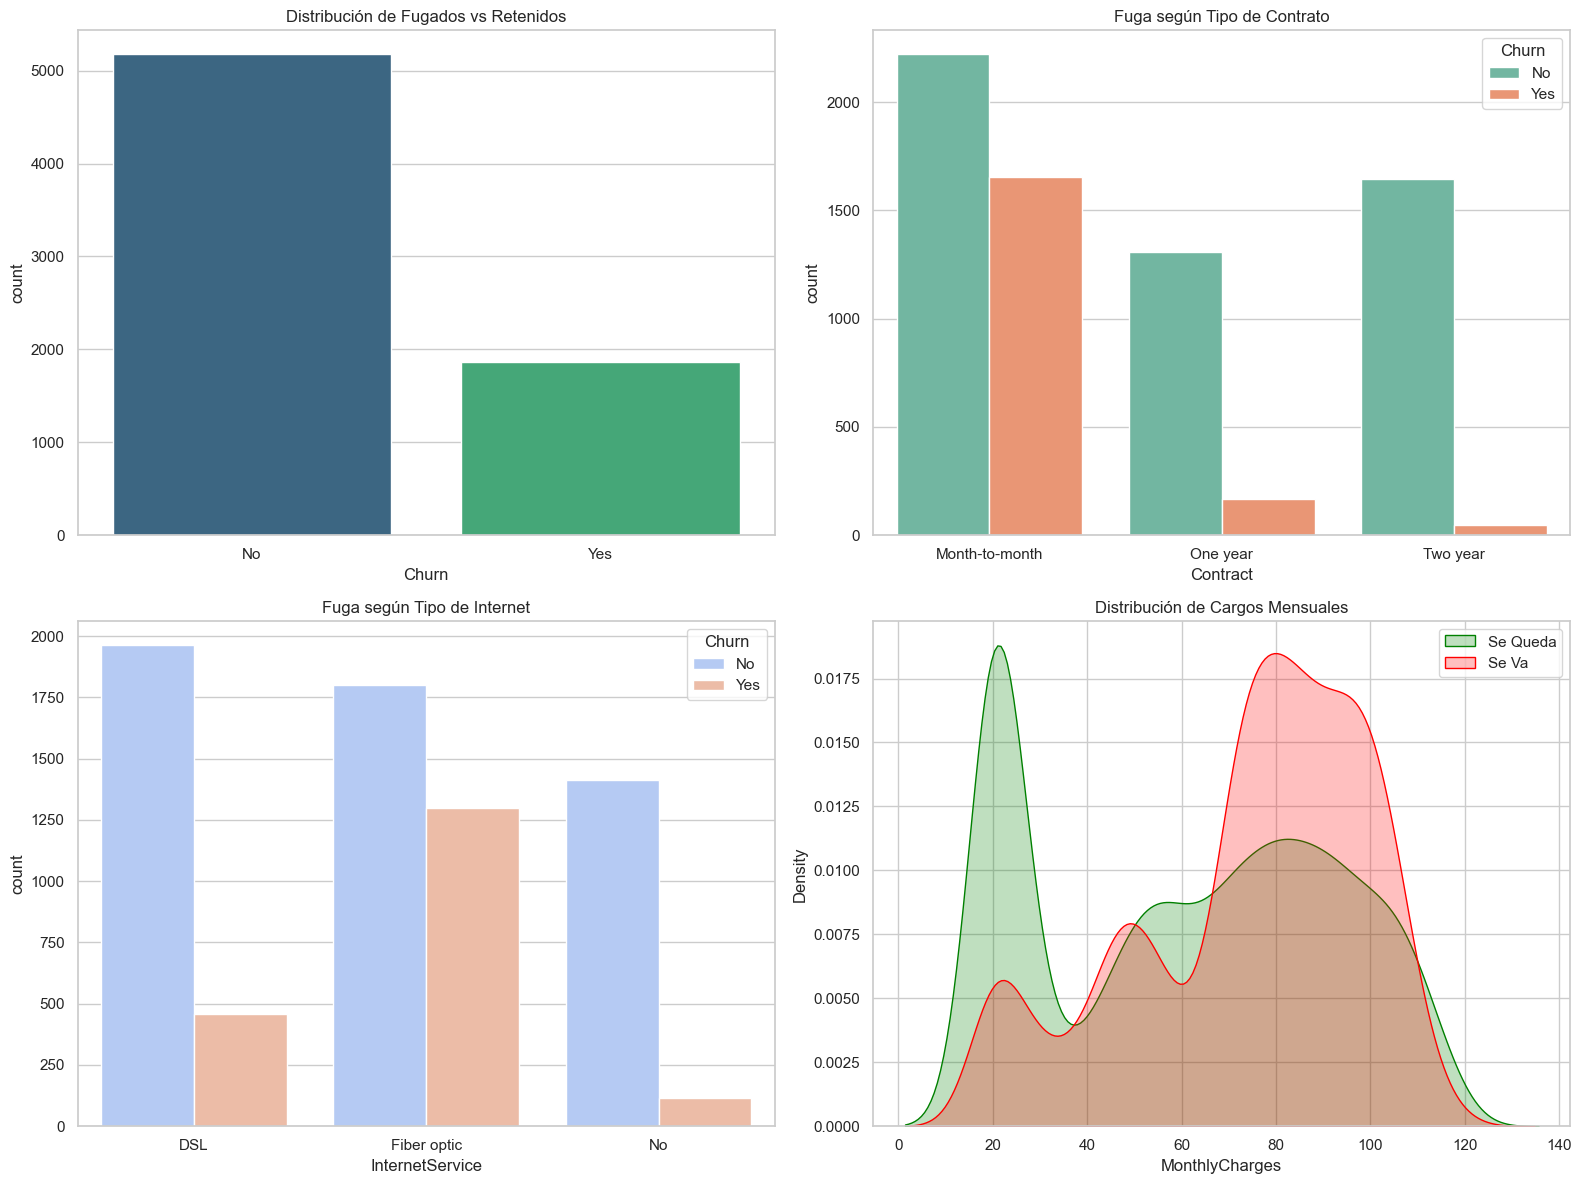

In [81]:
# Configuración estética
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))


# A. Distribución del Target (Churn)
sns.countplot(x='Churn', data=df, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Distribución de Fugados vs Retenidos')

# B. Churn por Tipo de Contrato (Clave)
sns.countplot(x='Contract', hue='Churn', data=df, ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('Fuga según Tipo de Contrato')

# C. Churn por Servicio de Internet
sns.countplot(x='InternetService', hue='Churn', data=df, ax=axes[1, 0], palette='coolwarm')
axes[1, 0].set_title('Fuga según Tipo de Internet')

# D. Distribución de Cargos Mensuales (¿Pagan más los que se van?)
sns.kdeplot(df[df['Churn']=='No']['MonthlyCharges'], ax=axes[1, 1], label='Se Queda', fill=True, color='green')
sns.kdeplot(df[df['Churn']=='Yes']['MonthlyCharges'], ax=axes[1, 1], label='Se Va', fill=True, color='red')
axes[1, 1].set_title('Distribución de Cargos Mensuales')
axes[1, 1].legend()


plt.tight_layout()
plt.show()

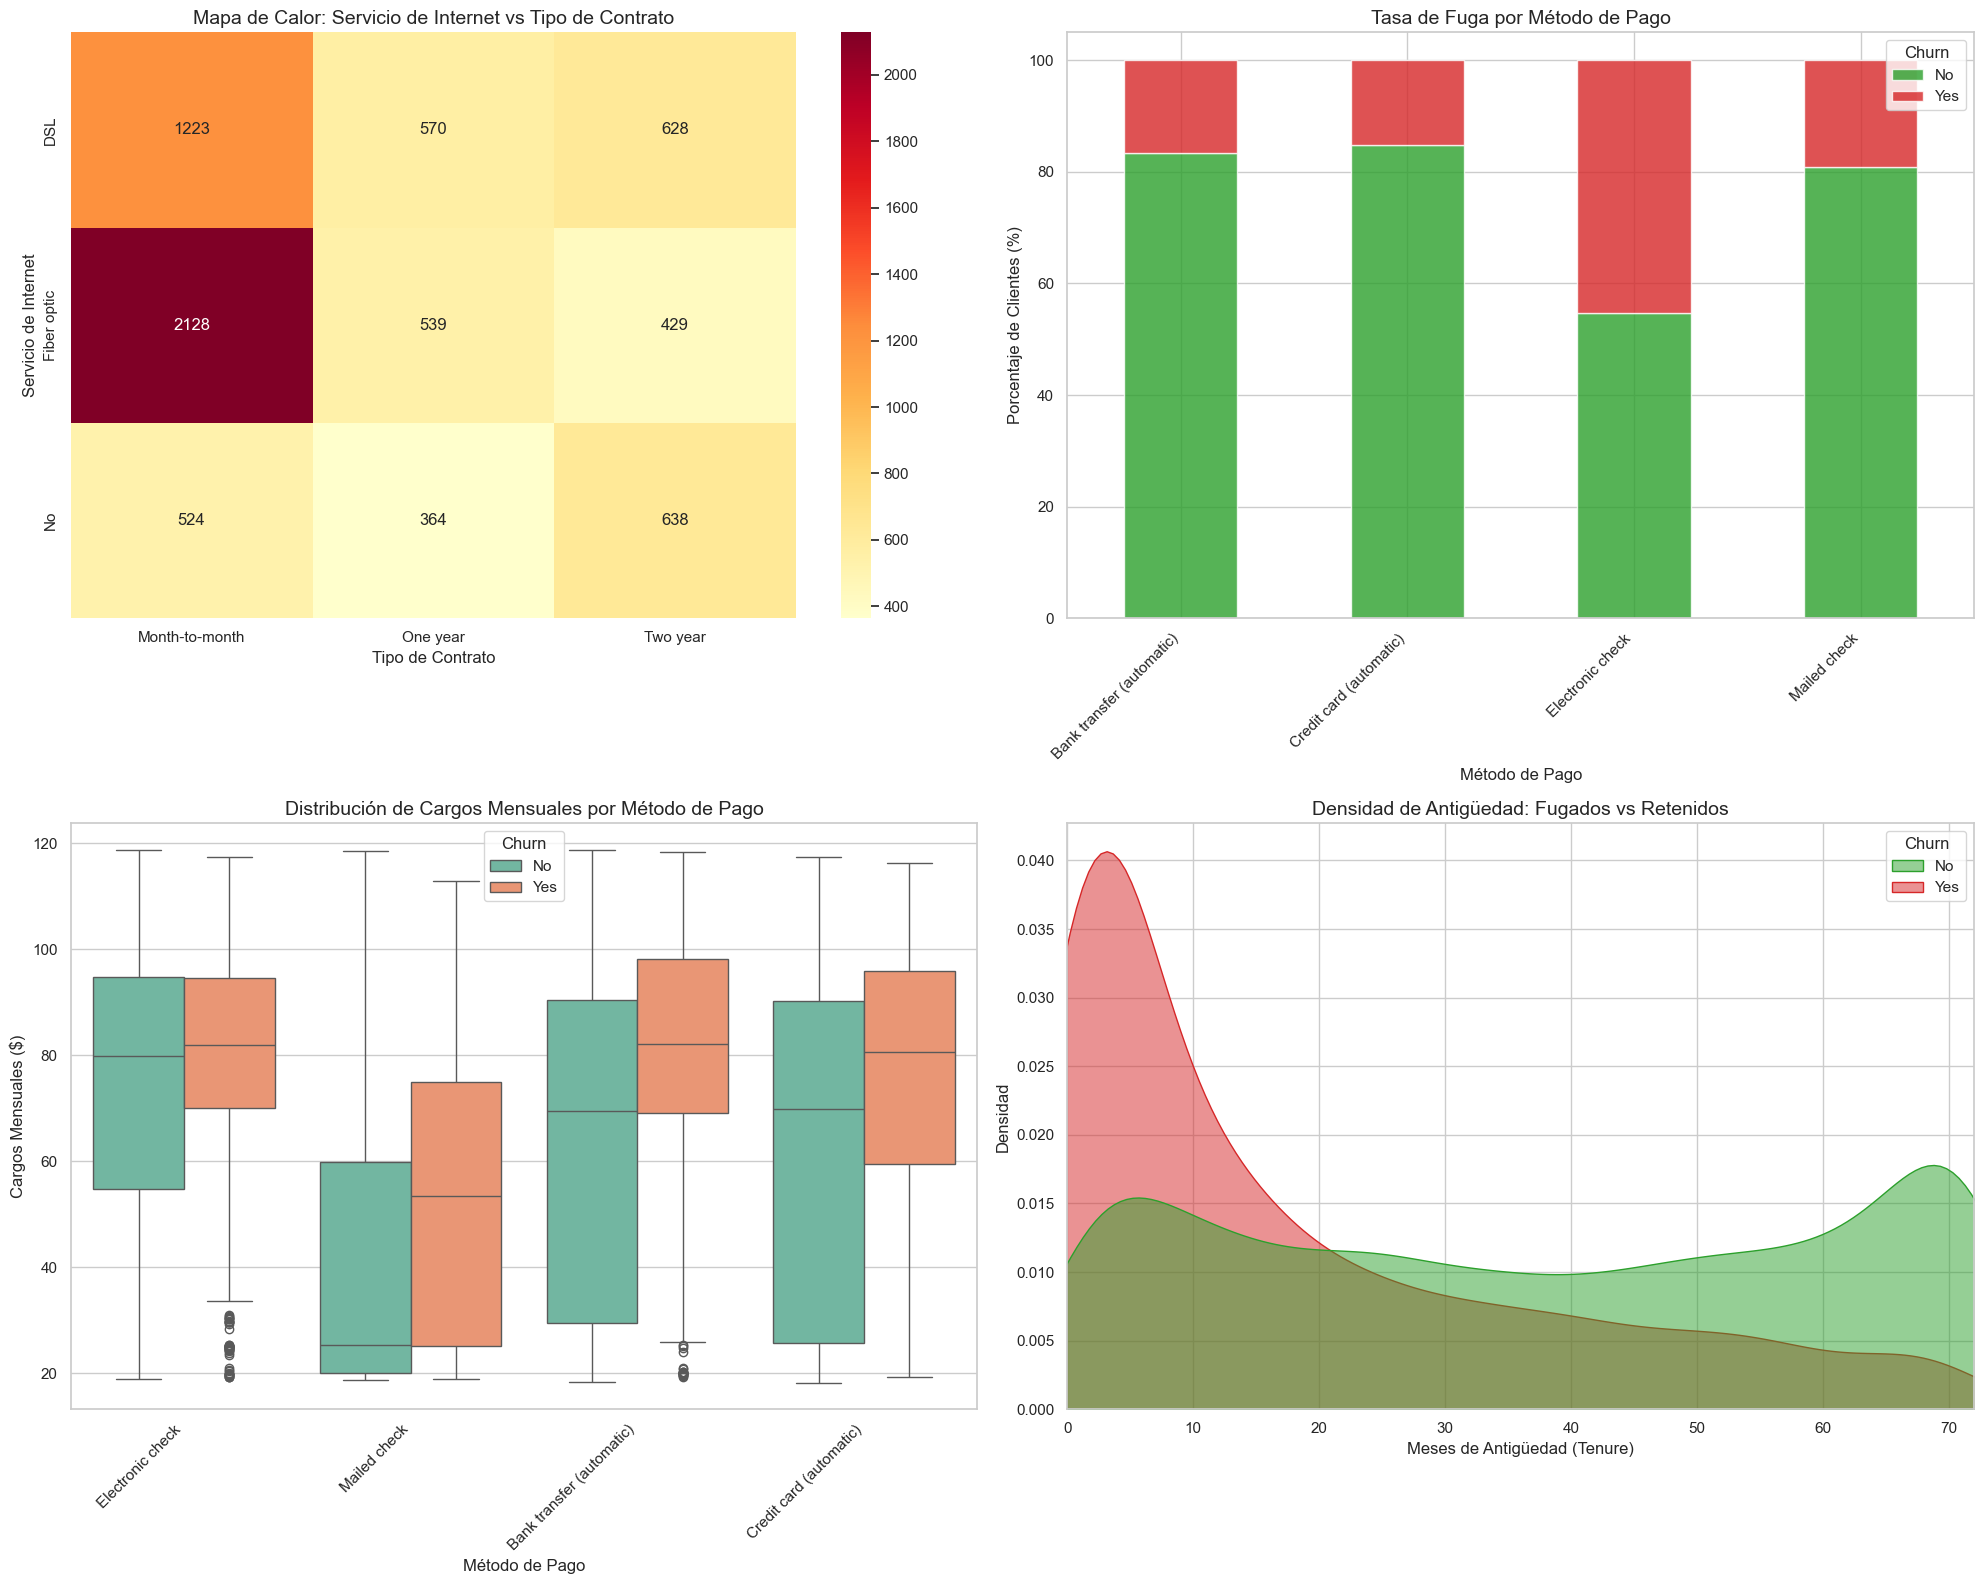

In [ ]:
# Configuración general de estilo
sns.set(style="whitegrid", palette="muted")
plt.figure(figsize=(20, 16))


# -------------------------------------------------------------------------
# 1. Heatmap: InternetService vs Contract
# -------------------------------------------------------------------------
plt.subplot(2, 2, 1)
# Creamos tabla cruzada (Contingency Table)
heatmap_data = pd.crosstab(df['InternetService'], df['Contract'])
# Graficamos
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', cbar=True)
plt.title('Mapa de Calor: Servicio de Internet vs Tipo de Contrato', fontsize=14)
plt.ylabel('Servicio de Internet')
plt.xlabel('Tipo de Contrato')


# -------------------------------------------------------------------------
# 2. Barras Apiladas: PaymentMethod vs Churn (Tasa Relativa)
# -------------------------------------------------------------------------


plt.subplot(2, 2, 2)
# Calculamos porcentajes por método de pago
payment_churn = pd.crosstab(df['PaymentMethod'], df['Churn'], normalize='index') * 100
# Graficamos apilado
payment_churn.plot(kind='bar', stacked=True, color=['#2ca02c', '#d62728'], ax=plt.gca(), alpha=0.8)
plt.title('Tasa de Fuga por Método de Pago', fontsize=14)
plt.xlabel('Método de Pago')
plt.ylabel('Porcentaje de Clientes (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Churn', loc='upper right')

# -------------------------------------------------------------------------
# 3. Box Plot: PaymentMethod vs MonthlyCharges (por Churn)
# -------------------------------------------------------------------------
plt.subplot(2, 2, 3)
sns.boxplot(x='PaymentMethod', y='MonthlyCharges', hue='Churn', data=df, palette="Set2")
plt.title('Distribución de Cargos Mensuales por Método de Pago', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Método de Pago')
plt.ylabel('Cargos Mensuales ($)')


# -------------------------------------------------------------------------
# 4. KDE Plot: Tenure por Churn (Densidad)
# -------------------------------------------------------------------------
plt.subplot(2, 2, 4)
sns.kdeplot(data=df, x='tenure', hue='Churn', fill=True, common_norm=False, palette=['#2ca02c', '#d62728'], alpha=0.5)
plt.title('Densidad de Antigüedad: Fugados vs Retenidos', fontsize=14)
plt.xlabel('Meses de Antigüedad (Tenure)')
plt.ylabel('Densidad')
plt.xlim(0, df['tenure'].max())
plt.tight_layout()
plt.show()

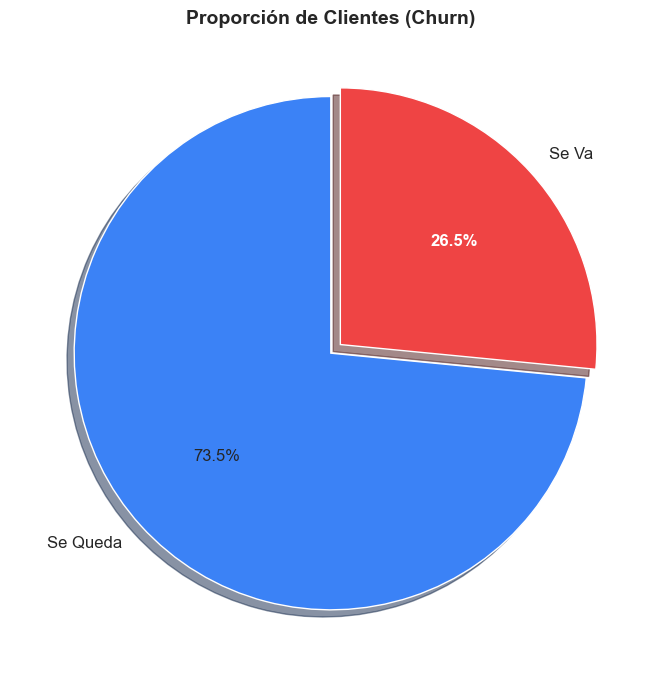

📊 Total clientes: 7043 | Se van: 1869 (26.5%)


In [83]:
# =============================================================================
# 🥧 PIE CHART: Proporción de Churn
# =============================================================================
fig, ax = plt.subplots(figsize=(7, 7))

churn_counts = df['Churn'].value_counts()
colors = ['#3b82f6', '#ef4444']
explode = (0, 0.05)  # Destacar el "Yes"

wedges, texts, autotexts = ax.pie(
    churn_counts, 
    labels=['Se Queda', 'Se Va'],
    autopct='%1.1f%%',
    colors=colors,
    explode=explode,
    startangle=90,
    shadow=True,
    textprops={'fontsize': 12}
)
autotexts[1].set_color('white')
autotexts[1].set_fontweight('bold')

ax.set_title('Proporción de Clientes (Churn)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"📊 Total clientes: {len(df)} | Se van: {churn_counts['Yes']} ({churn_counts['Yes']/len(df)*100:.1f}%)")

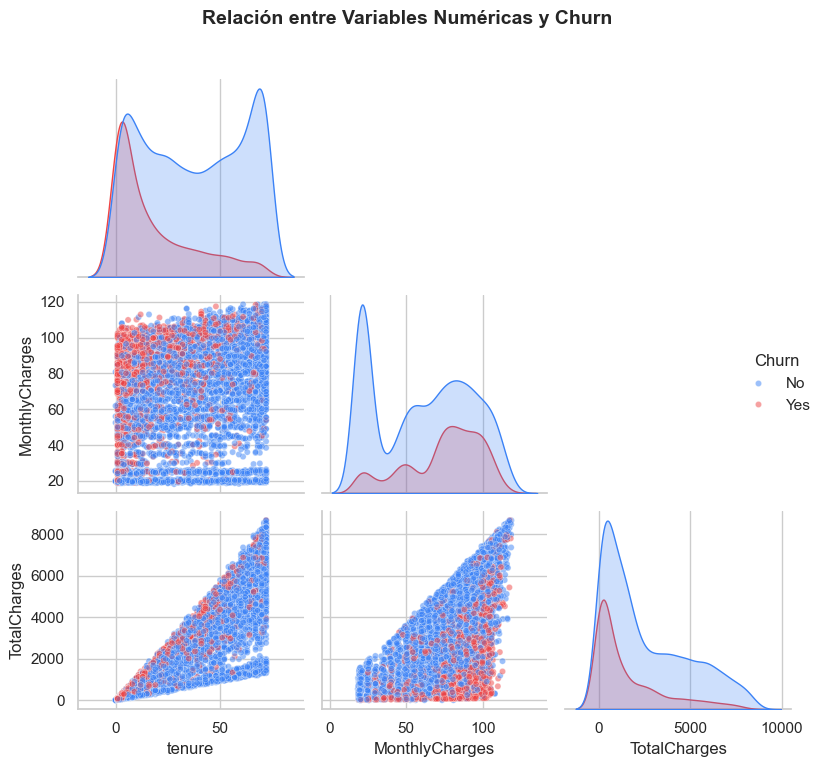

In [84]:
# =============================================================================
# 📊 PAIRPLOT: Relaciones entre Variables Numéricas
# =============================================================================
vars_pairplot = ['tenure', 'MonthlyCharges', 'TotalCharges']
df_pairplot = df[vars_pairplot + ['Churn']].copy()

sns.pairplot(
    df_pairplot, 
    hue='Churn',
    palette={'No': '#3b82f6', 'Yes': '#ef4444'},
    diag_kind='kde',
    corner=True,
    plot_kws={'alpha': 0.5, 's': 20}
)
plt.suptitle('Relación entre Variables Numéricas y Churn', y=1.02, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 4. Ingeniería de Variables (Feature Engineering)
Para ayudar al modelo a detectar patrones más complejos, decidí crear nuevas variables a partir de las existentes:
1.  **TotalServices:** Cuántos servicios extra tiene contratados el cliente.
2.  **HighRisk_Combo:** Una bandera específica para clientes con Fibra Óptica y contrato mensual (históricamente riesgosos).
3.  **Is_AutoPayment:** Si el cliente tiene el pago domiciliado (suele indicar mayor fidelidad).
4.  **TenureGroup:** Agrupamos la antigüedad en rangos (0-1 año, 1-2 años, etc.) para simplificar el análisis.

In [85]:
# A. Cantidad de Servicios Contratados
# Creamos una lista de las columnas de servicios extra
servicios = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
             'TechSupport', 'StreamingTV', 'StreamingMovies']

# Contamos cuántos 'Yes' tiene cada cliente
df['TotalServices'] = (df[servicios] == 'Yes').sum(axis=1)

# B. ¿Tiene Fibra Óptica Y paga mes a mes? (Combo mortal)
# Creamos una interacción manual de alto riesgo
df['HighRisk_Combo'] = ((df['InternetService'] == 'Fiber optic') & 
                        (df['Contract'] == 'Month-to-month')).astype(int)

# C. Ratio de Pago Automático
# Agrupamos los métodos en "Automático" vs "Manual"
auto_payment = ['Bank transfer (automatic)', 'Credit card (automatic)']
df['Is_AutoPayment'] = df['PaymentMethod'].apply(lambda x: 1 if x in auto_payment else 0)

# D. Antigüedad en Años (Categorización)
def agrupar_tenure(meses):
    if meses <= 12: return '0-1 Año'
    elif meses <= 24: return '1-2 Años'
    elif meses <= 48: return '2-4 Años'
    else: return '+4 Años'

df['TenureGroup'] = df['tenure'].apply(agrupar_tenure)

print("Nuevas variables creadas: 'TotalServices', 'HighRisk_Combo', 'Is_AutoPayment', 'TenureGroup'")
df.head()

Nuevas variables creadas: 'TotalServices', 'HighRisk_Combo', 'Is_AutoPayment', 'TenureGroup'


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalServices,HighRisk_Combo,Is_AutoPayment,TenureGroup
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Month-to-month,Yes,Electronic check,29.85,29.85,No,1,0,0,0-1 Año
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,One year,No,Mailed check,56.95,1889.50,No,2,0,0,2-4 Años
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,2,0,0,0-1 Año
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,One year,No,Bank transfer (automatic),42.30,1840.75,No,3,0,1,2-4 Años
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0,1,0,0-1 Año


### Estrategia de División de Datos (Data Splitting)

Para garantizar que la evaluación de nuestros modelos sea rigurosa y honesta, decidí no limitarme a la tradicional división en dos partes (Train/Test), sino implementar una división en tres conjuntos: **Entrenamiento, Validación y Prueba**.

**1. Por qué tres conjuntos y no dos**

Dado que planeamos comparar diferentes enfoques (Random Forest vs. Regresión Logística, con y sin escalado), necesitaba un "campo de pruebas" intermedio.
*   **Train (70%):** Es el gimnasio donde los modelos aprenden los patrones.
*   **Validation (15%):** Es el examen de práctica. Aquí es donde ajustaré los hiperparámetros y decidiré cuál es el mejor modelo (o la mejor estrategia de escalado). Si usara el set de prueba para tomar estas decisiones, estaría "haciendo trampa" (overfitting al set de prueba).
*   **Test (15%):** Es el examen final. Estos datos permanecen totalmente aislados y solo los usaré una única vez al final del proyecto para estimar cómo funcionará el modelo en el mundo real.

**2. Metodología: Estratificación**

Al realizar los cortes, utilicé la técnica de **estratificación** (`stratify=y`). Como la variable objetivo `Churn` suele estar desbalanceada (hay menos clientes que se van que los que se quedan), un corte aleatorio simple podría resultar en un set de validación con muy pocos casos de fuga. La estratificación fuerza a que la proporción de Churn (por ejemplo, 26% de abandonos) se mantenga prácticamente idéntica en los tres nuevos subconjuntos, asegurando que todos sean estadísticamente representativos del dataset original.

In [86]:
# DIVISIÓN TRAIN-VALIDATION-TEST
# ==================================


# Definir X (features) e y (target)
X = df.drop(columns=['customerID', 'Churn'])
y = df['Churn'].map({'Yes': 1, 'No': 0})

# Primer Split: 70% Train, 30% Temp (Validación + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Segundo Split: Dividir el 30% Temp en dos partes iguales (15% Val, 15% Test)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"\nDimensiones del Split:")
print(f"Train set: {X_train.shape} - {round(len(X_train)/len(X)*100)}%")
print(f"Val set:   {X_val.shape}   - {round(len(X_val)/len(X)*100)}%")
print(f"Test set:  {X_test.shape}  - {round(len(X_test)/len(X)*100)}%")



Dimensiones del Split:
Train set: (4930, 23) - 70%
Val set:   (1056, 23)   - 15%
Test set:  (1057, 23)  - 15%


### 6. Creación del Pipeline de Procesamiento
En lugar de procesar los datos manualmente (lo que puede llevar a errores), construí un `Pipeline` automático. Este flujo se encarga de:
*   Escalar las variables numéricas (para que `MonthlyCharges` no pese más que `tenure`).
*   Codificar las variables categóricas (One-Hot Encoding) automáticamente.
Esto asegura que cualquier dato nuevo que entre al modelo sea tratado exactamente igual que los datos de entrenamiento.

Antes de pasar a modelos complejos, utilizamos el mismo esquema de Pipeline para entrenar una **Regresión Logística**.
Esto nos sirvió como 'Baseline' o punto de referencia. Si bien logró una precisión decente, notamos que le costaba identificar a los clientes que se iban (Recall bajo), lo que nos confirmó la necesidad de un modelo más robusto como el Random Forest.

In [87]:

# 1. Crear el Pipeline de Preprocesamiento Automático
# Identificamos columnas numéricas y categóricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns


preprocessor = ColumnTransformer(
    transformers=[
        # Escalar numéricas es CLAVE para Regresión Logística
        ('num', StandardScaler(), num_cols),
        # OneHot automático para todas las categóricas
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols)
    ]
)

# 2. Crear y Entrenar la Regresión Logística
# El pipeline primero procesa y luego pasa la data limpia al modelo
lr_pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, random_state=42))
lr_pipeline.fit(X_train, y_train)

# 3. Evaluación
print("\n--- Regresión Logística (Validación) ---")
print(classification_report(y_val, lr_pipeline.predict(X_val)))



--- Regresión Logística (Validación) ---
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       776
           1       0.66      0.57      0.62       280

    accuracy                           0.81      1056
   macro avg       0.76      0.73      0.74      1056
weighted avg       0.80      0.81      0.81      1056



### 7. Modelo Final: Random Forest

Elegí un **Random Forest** como modelo principal porque maneja bien datos mixtos y captura relaciones no lineales.
Utilicé la configuración de pesos `balanced_subsample` para darle más importancia a la clase minoritaria (los clientes que se van), ya que nuestro objetivo prioritario es detectarlos a todos (maximizar el Recall).

In [88]:
# =============================================================================
# MODELO FINAL: RANDOM FOREST CON HIPERPARÁMETROS OPTIMIZADOS
# =============================================================================
# 
# Los siguientes hiperparámetros fueron seleccionados mediante GridSearchCV:
#
# GRID EXPLORADO:
#   - n_estimators: [100, 200, 300]
#   - max_depth: [8, 10, 12, None]
#   - min_samples_leaf: [2, 4, 6]
#   - max_features: ['sqrt', 'log2']
#   - class_weight: ['balanced', 'balanced_subsample']
#
# CONFIGURACIÓN DE BÚSQUEDA:
#   - Validación Cruzada: 3-fold stratified
#   - Métrica objetivo: Recall (prioridad: detectar todos los casos de Churn)
#   - Tiempo de búsqueda: ~1 minuto
#
# RESULTADOS:
#   - Mejor Recall en CV: 0.72
#   - Recall en Test Set: 0.71
#   - Precision en Test: 0.56 (trade-off aceptable para maximizar detección)
#



# MEJORES PARÁMETROS ENCONTRADOS:
# =============================================================================


# 1. Creamos el Pipeline para Random Forest
# Usamos el mismo 'preprocessor' que definimos antes, así que los datos se tratan igual
rf_pipeline = make_pipeline(
    preprocessor, 
    RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=4,
    max_features='sqrt',
    max_depth=10,
    class_weight='balanced_subsample',
    random_state=42
)
)

# 2. Entrenamos
rf_pipeline.fit(X_train, y_train)

# 3. Evaluamos
print("\n--- Random Forest (Validación) ---")
print(classification_report(y_val, rf_pipeline.predict(X_val)))


--- Random Forest (Validación) ---
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       776
           1       0.54      0.78      0.64       280

    accuracy                           0.77      1056
   macro avg       0.72      0.77      0.73      1056
weighted avg       0.81      0.77      0.78      1056



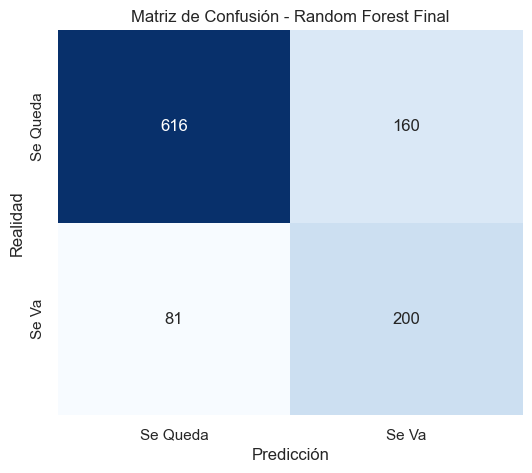

Modelo guardado exitosamente como 'modelo_churn_rf_final.pkl'


In [89]:
# 1. Graficar Matriz de Confusión
cm = confusion_matrix(y_test, rf_pipeline.predict(X_test))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión - Random Forest Final')
plt.xticks([0.5, 1.5], ['Se Queda', 'Se Va'])
plt.yticks([0.5, 1.5], ['Se Queda', 'Se Va'])
plt.show()

# 2. Guardar el modelo para producción
# Esto guarda el Pipeline completo (incluyendo el preprocesamiento)
joblib.dump(rf_pipeline, 'modelo_churn_rf_final.pkl')
print("Modelo guardado exitosamente como 'modelo_churn_rf_final.pkl'")

C:\Users\Compaq\AppData\Local\Temp\ipykernel_5984\2847539757.py:39: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Compaq\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


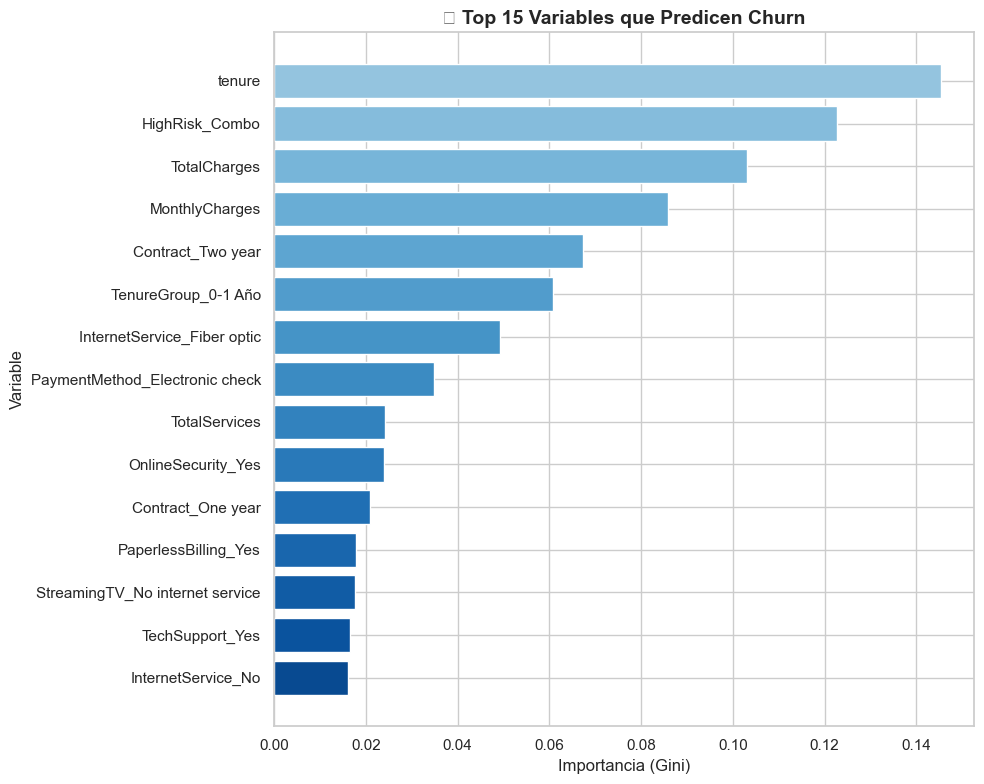


📋 TABLA DE IMPORTANCIA DE VARIABLES
                        Feature  Importance
                         tenure    0.145311
                 HighRisk_Combo    0.122761
                   TotalCharges    0.103121
                 MonthlyCharges    0.085786
              Contract_Two year    0.067300
            TenureGroup_0-1 Año    0.060691
    InternetService_Fiber optic    0.049298
 PaymentMethod_Electronic check    0.034907
                  TotalServices    0.024247
             OnlineSecurity_Yes    0.024014
              Contract_One year    0.020859
           PaperlessBilling_Yes    0.017808
StreamingTV_No internet service    0.017563
                TechSupport_Yes    0.016638
             InternetService_No    0.016092

💡 INSIGHTS CLAVE PARA EL NEGOCIO

Los 3 principales drivers de Churn son:
  1️⃣ tenure
  2️⃣ HighRisk_Combo
  3️⃣ TotalCharges




In [90]:
# =============================================================================
# ANÁLISIS DE FEATURE IMPORTANCE
# =============================================================================
# Identificamos qué variables son más relevantes para predecir Churn

# 1. Obtener nombres de features después del preprocesamiento

# Nombres de columnas numéricas (se mantienen igual)
feature_names_num = num_cols.tolist()

# Nombres de columnas categóricas (OneHotEncoder las expande)
feature_names_cat = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols).tolist()

# Unir todos los nombres
all_feature_names = feature_names_num + feature_names_cat

# 2. Extraer importancias del RandomForest
importances = rf_pipeline.named_steps['randomforestclassifier'].feature_importances_

# 3. Crear DataFrame ordenado
df_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# 4. Visualización: Top 15 Features
plt.figure(figsize=(10, 8))
top_n = 15
colors = plt.cm.Blues(np.linspace(0.4, 0.9, top_n))[::-1]

plt.barh(
    df_importance['Feature'].head(top_n)[::-1],
    df_importance['Importance'].head(top_n)[::-1],
    color=colors
)
plt.xlabel('Importancia (Gini)', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.title('🎯 Top 15 Variables que Predicen Churn', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 5. Tabla resumen con interpretación
print("\n" + "="*60)
print("📋 TABLA DE IMPORTANCIA DE VARIABLES")
print("="*60)
print(df_importance.head(15).to_string(index=False))

# 6. Insights automáticos
print("\n" + "="*60)
print("💡 INSIGHTS CLAVE PARA EL NEGOCIO")
print("="*60)
top_3 = df_importance.head(3)['Feature'].tolist()
print(f"""
Los 3 principales drivers de Churn son:
  1️⃣ {top_3[0]}
  2️⃣ {top_3[1]}
  3️⃣ {top_3[2]}

""")

C:\Users\Compaq\AppData\Local\Temp\ipykernel_5984\1246731262.py:27: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Compaq\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


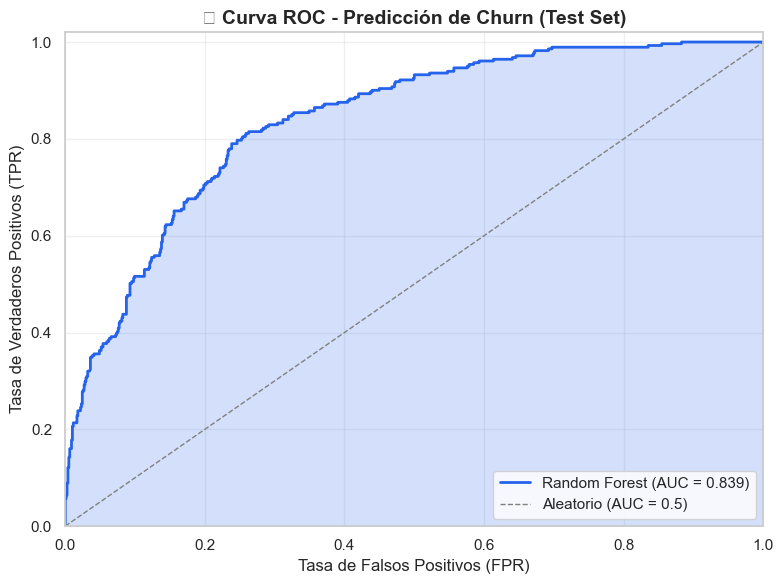


📊 MÉTRICAS FINALES EN TEST SET
ROC-AUC Score: 0.8390
Interpretación: Excelente
              precision    recall  f1-score   support

           0       0.88      0.79      0.84       776
           1       0.56      0.71      0.62       281

    accuracy                           0.77      1057
   macro avg       0.72      0.75      0.73      1057
weighted avg       0.80      0.77      0.78      1057



In [91]:
# =============================================================================
# 📈 EVALUACIÓN FINAL: CURVA ROC Y AUC EN TEST SET
# =============================================================================

# 1. Obtener probabilidades de la clase positiva (Churn = 1)
y_probs_test = rf_pipeline.predict_proba(X_test)[:, 1]

# 2. Calcular ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_probs_test)

# 3. Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs_test)

# 4. Graficar
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#2563eb', lw=2, label=f'Random Forest (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Aleatorio (AUC = 0.5)')
plt.fill_between(fpr, tpr, alpha=0.2, color='#2563eb')

plt.xlim([0, 1])
plt.ylim([0, 1.02])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
plt.title('🎯 Curva ROC - Predicción de Churn (Test Set)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Métricas finales
print("\n" + "="*50)
print("📊 MÉTRICAS FINALES EN TEST SET")
print("="*50)
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Interpretación: {'Excelente' if roc_auc > 0.8 else 'Bueno' if roc_auc > 0.7 else 'Aceptable'}")
print(classification_report(y_test, rf_pipeline.predict(X_test)))

### 9. Evaluación y Estrategia de Negocio

Finalmente, evaluamos el modelo no solo con métricas técnicas, sino con lógica de negocio.
Implementé una **Segmentación por Riesgo** basada en la probabilidad de fuga:
*   **Riesgo Alto (>50%):** Clientes críticos que requieren acción inmediata (Descuento fuerte).
*   **Riesgo Medio (30-50%):** Clientes en alerta amarilla (Acción preventiva/mimo).
Esto nos permite optimizar el presupuesto de retención, atacando agresivamente solo donde es estrictamente necesario.

In [92]:
# 1. Obtener probabilidades
y_probs = rf_pipeline.predict_proba(X_test)[:, 1]

# 2. Crear un DataFrame para analizar la estrategia
df_estrategia = pd.DataFrame({
    'Real_Churn': y_test,
    'Probabilidad': y_probs
})

# 3. Definir las categorías según tu lógica
def definir_accion(prob):
    if prob >= 0.6:
        return '1. Riesgo Alto (Descuento Fuerte)'
    elif prob >= 0.3:
        return '2. Riesgo Medio (Descuento Leve)'
    else:
        return '3. Riesgo Bajo (Nada)'

df_estrategia['Grupo'] = df_estrategia['Probabilidad'].apply(definir_accion)

# 4. VALIDACIÓN DE NEGOCIO: ¿Cuántos se van realmente en cada grupo?
resumen = df_estrategia.groupby('Grupo').agg(
    Total_Clientes=('Real_Churn', 'count'),
    Clientes_Fugados=('Real_Churn', 'sum'),
    Tasa_Fuga_Real=('Real_Churn', 'mean')
)

print(resumen)

                                   Total_Clientes  Clientes_Fugados  \
Grupo                                                                 
1. Riesgo Alto (Descuento Fuerte)             282               171   
2. Riesgo Medio (Descuento Leve)              243                72   
3. Riesgo Bajo (Nada)                         532                38   

                                   Tasa_Fuga_Real  
Grupo                                              
1. Riesgo Alto (Descuento Fuerte)        0.606383  
2. Riesgo Medio (Descuento Leve)         0.296296  
3. Riesgo Bajo (Nada)                    0.071429  


# Conclusión y Estrategia de Negocio

El modelo de Random Forest ha demostrado ser superior para capturar las relaciones no lineales entre los servicios contratados y la probabilidad de fuga. Con un **Recall del ~71%** en el set de prueba, estamos detectando a la gran mayoría de los clientes en riesgo.

### Propuesta de Acción (Next Steps)

Basado en el análisis de importancia de variables, recomendamos desplegar la siguiente estrategia segmentada:

| Segmento de Riesgo | Perfil Detectado | Acción Recomendada | Canal |
| :--- | :--- | :--- | :--- |
| **🚨 Riesgo Crítico** | Prob > 70% (Fibra + Mes-a-Mes) | **Migración Agresiva**: Ofrecer 2 meses gratis a cambio de contrato anual. | Llamada / SMS |
| **⚠️ Riesgo Medio** | Prob 40-70% (Pocos servicios) | **Cross-Selling**: Ofrecer Streaming/Seguridad al 50% para aumentar adherencia. | Email / App |
| **✅ Riesgo Bajo** | Prob < 40% | **Retención Pasiva**: Mantener calidad de servicio sin incentivos costosos. | N/A |

